<a href="https://colab.research.google.com/github/kaneelgit/ML-DL-Algorithms/blob/main/contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = '6'><center> **Contrastive Learning** </center></font>

Paper - https://arxiv.org/pdf/2002.05709.pdf

In [4]:
#import libraries
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

In [5]:
#hyperparameters
AUTO = tf.data.AUTOTUNE
bs = 512
labeled_bs = 32
test_bs = 32
epochs = 100
crop_to = 32
img_size = 32
random_seed = 26 
project_dim = 2048
latent_dim = 512
weight_decay = 0.0005


batch_size = 512
temp = 0.1

contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [6]:
#get the cifar-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#normalize
x_train = x_train/255
x_test = x_test/255

#lets devide the test to labeled train and test
x_train_labeled = x_test[:5000]
y_train_labeled = y_test[:5000]

x_test = x_test[5000:]
y_test = y_test[5000:]

print(f'Total training images: {x_train.shape[0]} & Shape of training data: {x_train.shape}')
print(f'Total training labeled images: {x_train_labeled.shape[0]} & Shape of training labeled data: {x_train_labeled.shape}')
print(f'Total testing images: {x_test.shape[0]} & Shape of testing data: {x_test.shape}')

170508288/170498071 [==============================] - 11s 0us/step
Total training images: 50000 & Shape of training data: (50000, 32, 32, 3)
Total training labeled images: 5000 & Shape of training labeled data: (5000, 32, 32, 3)
Total testing images: 5000 & Shape of testing data: (5000, 32, 32, 3)


In [7]:
#class for image audmentations

class data_augmentation(layers.Layer):

  def __init__(self, **kwargs):
    super(data_augmentation, self).__init__()

  def call(self, sample):
    
    sample = self.random_apply(self.color_jitter, sample, 0.8)
    sample = self.random_apply(self.color_drop, sample, 0.2)    

    return sample

  def color_jitter(self, x, s = 1, p = 0.8):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta = 0.8 * s)
    x = tf.image.random_contrast(x, lower = 1 - 0.8 * s, upper = 1 + 0.8 * s)
    x = tf.image.random_saturation(x, lower = 1 - 0.8 * s, upper = 1 + 0.8 * s)
    x = tf.image.random_hue(x, max_delta = 0.2 * s)
    x = tf.clip_by_value(x, 0, 1)
    return x

  def color_drop(self, x, p = 0.2):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 1, 3])
    return x

  def random_apply(self, func, x, p):
    return tf.cond(
      tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


#create the data augmentation pipline
data_aug = tf.keras.models.Sequential([tf.keras.layers.Lambda(data_augmentation()), tf.keras.layers.RandomCrop(24, 24), tf.keras.layers.Resizing(32, 32)])

In [9]:
#create tensorflow dataset objects

#create two datasets
train_ds_unlabeled = tf.data.Dataset.from_tensor_slices(x_train)
train_ds_unlabeled = (train_ds_unlabeled.shuffle(1024, seed = random_seed).batch(bs).prefetch(AUTO))

train_ds_labeled = tf.data.Dataset.from_tensor_slices((x_train_labeled, y_train_labeled))
train_ds_labeled = (train_ds_labeled.shuffle(1024, seed = random_seed).batch(bs).prefetch(AUTO))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (test_ds.batch(bs).prefetch(AUTO))

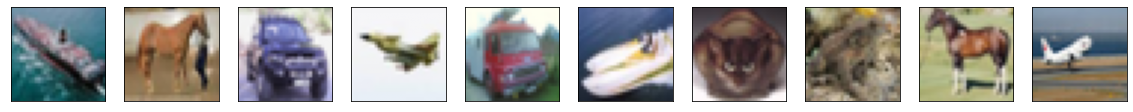

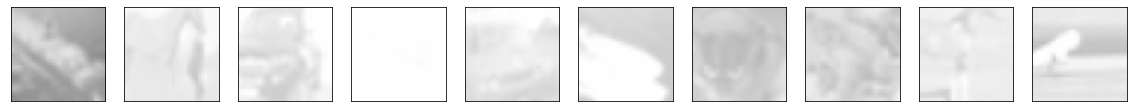

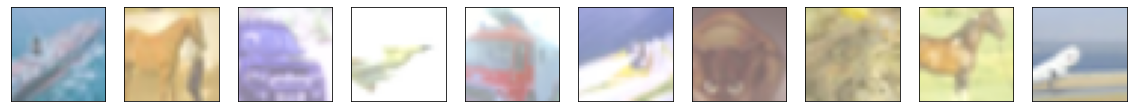

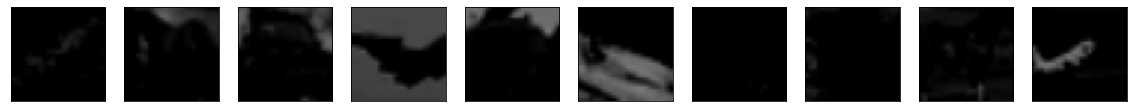

In [10]:
#checkout the augmentations
samp, lab = next(iter(train_ds_labeled))

def plot_images(samp):
  #plot figure
  fig, ax = plt.subplots(1, 10, figsize = (20, 2))
  
  for i, s in enumerate(samp[:10]):
    ax[i].imshow(s)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plot_images(samp)
plot_images(data_aug(samp))
plot_images(data_aug(samp))
plot_images(data_aug(samp))

In [1]:
#resnet 
def base_encoder():
  #get the resnet50 model
  base_model = tf.keras.applications.ResNet50(include_top = False, weights = None, input_shape = (32, 32, 3))
  base_model.trainable = True
  
  #define input
  input = tf.keras.layers.Input((32, 32, 3))

  #model
  x = base_model(input, training = True)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
  output = tf.keras.layers.Dense(512, activation = 'relu')(x)
  # output = tf.keras.layers.Dense(124, activation = 'relu')(x)

  return tf.keras.Model(input, output)

In [11]:
# #see the resnet50 model performance
base = base_encoder()
base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
Total params: 26,210,688
Trainable params: 26,157,568
Non-trainable params: 53,120
_________________________________________________________________


In [24]:
def projection_head():
  #input
  input = tf.keras.layers.Input(shape = (512))
  output = tf.keras.layers.Dense(124, activation = 'relu')(input)

  return tf.keras.Model(input, output)

proj_head = projection_head()
proj_head.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_3 (Dense)             (None, 124)               63612     
                                                                 
Total params: 63,612
Trainable params: 63,612
Non-trainable params: 0
_________________________________________________________________


In [26]:
#sample inputs
xi = tf.random.uniform([16, 32, 32, 3])
xj = tf.random.uniform([16, 32, 32, 3])

#sample
xi = next(iter(train_ds_unlabeled))
xj = next(iter(train_ds_unlabeled))

#use encoder to get the representations
hi = base(xi)
hj = base(xj)

#get zi and zj from the projection head
zi = proj_head(hi)
zj = proj_head(hj)

zi = tf.keras.backend.l2_normalize(zi, axis = 1)
zj = tf.keras.backend.l2_normalize(zj, axis = 1)

#concatenate zi and zj to make a 2N tensor
x = tf.keras.backend.concatenate((zi, zj), axis = 0)

#calculate the similarity matrix for the 2N vector
sim_mat = tf.keras.backend.dot(x, tf.keras.backend.transpose(x))
sim_mat = tf.keras.backend.exp(sim_mat/temp)

diag = np.zeros(sim_mat.shape[0])

tf.linalg.set_diag(sim_mat, diag)

loss = contrastive_loss(zi, zj, 1)

loss

<tf.Tensor: shape=(), dtype=float32, numpy=6.930163>

In [27]:
#similarity mat
def contrastive_loss(zi, zj, temp):
  """
  This function calculate the contrastive loss given two image representation vectors zi, zj
  temp - temperature parameter
  """
  #l2 normalize the image representations
  zi = tf.keras.backend.l2_normalize(zi, axis = 1)
  zj = tf.keras.backend.l2_normalize(zj, axis = 1)

  #concatenate zi and zj to make a 2N tensor
  x = tf.keras.backend.concatenate((zi, zj), axis = 0)
  
  #calculate the similarity matrix for the 2N vector
  sim_mat = tf.keras.backend.dot(x, tf.keras.backend.transpose(x))
  sim_mat = tf.keras.backend.exp(sim_mat/temp)

  #set the diagonal values of the sim_mat to zero
  diagonal = np.zeros(sim_mat.shape[0])
  sim_mat = tf.linalg.set_diag(sim_mat, diagonal)

  #now calculate the similarity values for zi and zj for matching pairs
  sim_match = tf.keras.backend.exp(tf.keras.backend.sum(zi * zj, axis = -1)/temp)

  #concatenate the similarity matrix
  sim_match = tf.keras.backend.concatenate((sim_match, sim_match), axis = 0)
  
  cont_loss = tf.math.reduce_mean(-tf.keras.backend.log(sim_match / tf.keras.backend.sum(sim_mat, axis = -1)))
  
  return cont_loss


In [39]:
#contrastive learning 

#training step
@tf.function
def train_step(xi, xj, base, proj_head, optimizer, temp):
  
  with tf.GradientTape() as tape:

    batch_size = xi.shape[0]
    
    #use encoder to get the representations
    hi = base(xi)
    hj = base(xj)

    #projection head
    zi = proj_head(hi)
    zj = proj_head(hj)

    #normalize zi and zj
    zi = tf.math.l2_normalize(zi, axis = 1)
    zj = tf.math.l2_normalize(zj, axis = 1)

    #calculate the contrastive loss
    loss = contrastive_loss(zi, zj, temp = temp)

  gradients = tape.gradient(loss, base.trainable_variables + proj_head.trainable_variables)
  optimizer.apply_gradients(zip(gradients, base.trainable_variables + proj_head.trainable_variables))

  return loss

In [40]:
def simclr(base, proj_head, dataset, optimizer, temp = 0.1, epochs = 20):

  for epoch in tqdm(range(epochs)):
    print(epoch)
    losses_epoch = []

    for batch in dataset:
      xi = data_aug(batch)
      xj = data_aug(batch)

      loss = train_step(xi, xj, base, proj_head, optimizer, temp)
      losses_epoch.append(loss.numpy())
      

    mean_loss_epoch = np.mean(losses_epoch)
    print(f'epoch: {epoch + 1}: loss {mean_loss_epoch:.3f}')

  return mean_loss_epoch, base

In [41]:
#get optimizer
optimizer = tf.keras.optimizers.Adam()

final_loss, base = simclr(base, proj_head, train_ds_unlabeled, optimizer)

  0%|          | 0/20 [00:00<?, ?it/s]

0
epoch: 1: loss 6.619
1
epoch: 2: loss 6.407
2
epoch: 3: loss 6.402
3
epoch: 4: loss 6.361
4
epoch: 5: loss 6.372
5
epoch: 6: loss 6.364
6
epoch: 7: loss 6.350
7
epoch: 8: loss 6.316
8
epoch: 9: loss 6.037
9
epoch: 10: loss 5.994
10


KeyboardInterrupt: ignored